Calculate the following geometries for Tien Chau sand-spit
- spit length
- spit orientation
- spit area
- gap width


## Retrieve shoreline data

Obtain the shoreline polygons from file `data/TIENCHAU/TIENCHAU_output_lines.geojson`

In [2]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import pandas as pd

[12161544.592345279, 1501773.7025970463]


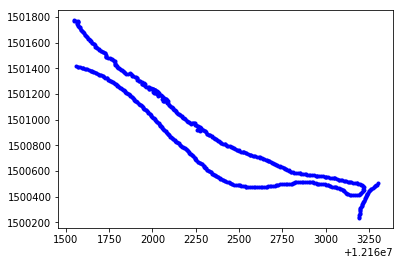

In [20]:
with open('data/TIENCHAU/TIENCHAU_output_lines.geojson') as f:
    data = json.load(f)
    
len(data['features'][0]['geometry']['coordinates'])

coords = data['features'][-10]['geometry']['coordinates']
print(coords[0])
xs = []
ys = []

for coord in coords:
    xs += [coord[0]]
    ys += [coord[1]]

#print(xs, ys)
plt.plot(xs, ys, 'b.')

In [10]:
data['features'][-1]['properties']['date']

'2020-08-15 03:24:25'

Find the part containing the southern shore of the inlet (consecutive coordinates, from end point, that X > 12163150 m).

12163302.903848333 1500506.5759994506
312086 1477216
312085 1477213
312082 1477203
312076 1477196
312066 1477194
312063 1477192
312056 1477184
312055 1477182
312050 1477172
312046 1477161
312046 1477160
312040 1477151
312036 1477142
312034 1477141
312031 1477130
312026 1477120
312025 1477119
312020 1477109
312015 1477100
312015 1477099
312011 1477089
312009 1477078
312005 1477070
312004 1477068
312001 1477058
312000 1477047
311998 1477037
311995 1477033
311990 1477026
311986 1477016
311986 1477006
311985 1476996
311985 1476995
311981 1476985
311978 1476975
311978 1476964
311975 1476954
311975 1476953
311971 1476944
311971 1476933


(311965.2322028909, 312092.69773621147, 1476919.5839332084, 1477230.7184787956)

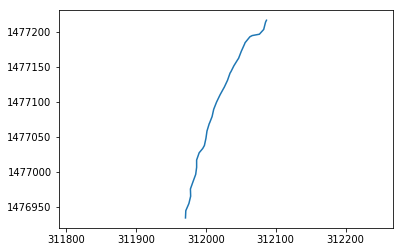

In [5]:
south_shore_coords_X = []
south_shore_coords_Y = []
count = -1  # starting from end

while coords[count][0] > 12163150:
    south_shore_coords_X += [coords[count][0]]
    south_shore_coords_Y += [coords[count][1]]
    count -= 1
    
print(south_shore_coords_X[0], south_shore_coords_Y[0])

# len(south_shore_coords_X) == len(south_shore_coords_Y) == 40
# scarp cooridnates are wrong? 311971, 1476905
shiftX = 311971 - 12163200 + 13
shiftY = 1476905 - 1500200 + 5
scarp_UTM = {'X':311612-shiftX, 'Y':1477289-shiftY}  # (12162828, 1500579)

south_shore_coords_X = [Xi + shiftX for Xi in south_shore_coords_X]
south_shore_coords_Y = [Yi + shiftY for Yi in south_shore_coords_Y]

for i in range(len(south_shore_coords_X)):
    print(int(south_shore_coords_X[i]), int(south_shore_coords_Y[i]))

plt.plot(south_shore_coords_X, south_shore_coords_Y)
plt.axis('equal')

In [76]:
# Another set of digitized coordinates from Google Earth, 
# which is equivalent to (south_shore_coords_X, south_shore_coords_Y)
rocky_coast = ((311971, 1476905), (311989, 1476957), (311995, 1476998), 
               (312000, 1477033), (312009, 1477068), (312020, 1477100), 
               (312036, 1477134), (312048, 1477162), (312063, 1477186), 
               (312085, 1477214), (312101, 1477240))

## Calculate geometries

The coordinates of southern rocky coast is digitized from Google earth image. In this case, tidal correction is not needed because this coast is fixed (steep revetment).

In [3]:
import math
import numpy as np

# auxiliary function to compute angle for sand spit orientation
def ang(dx, dy):
    return (90 - math.degrees(math.atan2(dy,dx))) % 360

# shoelace formula, https://stackoverflow.com/a/30408825/4956603
def PolyArea(X,Y):
    return 0.5*np.abs(np.dot(X,np.roll(Y,1))-np.dot(Y,np.roll(X,1)))

# https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line#Line_defined_by_two_points
def dist_point_to_line(xp,yp,x1,y1,x2,y2):
    return abs((y2-y1)*xp - (x2-x1)*yp + x2*y1 - x1*y2) / math.sqrt((y2-y1)**2 + (x2-x1)**2)

### from GeoJSON (Obsolete)

In [5]:
geom = []   # to store the geometries for various shorelines

X0 = 311612 # scarp
Y0 = 1477289 # scarp
shiftX = 311612 - 12162742 + 13
shiftY = 1477289 - 1500604 - 5


for feature in data['features']:
    date = datetime.strptime(feature['properties']['date'], '%Y-%m-%d %H:%M:%S')
    if date < datetime(2016,6,13):
        continue
    coords = feature['geometry']['coordinates']
    xs = []
    ys = []
    max_dist = 0 # from the fixed point to the spit
    x_tip = 0   # to identify the spit
    y_tip = 0
    length = 0  # cumulative length alongshore
    maxlength = 0  # length of spit
    count = 0
    marked = False
    # print(coords[0][0], coords[0][1])
    for coord in coords:
        x = coord[0] + shiftX
        y = coord[1] + shiftY
        if x < X0:
            continue
        elif x < X0 and marked:
            count += 1
            print(count, end=".")
            break
        else:
            marked = True
            if 'xprev' in locals():
                seg = math.sqrt((x-xprev)**2 + (y-yprev)**2)
                if seg > 1500: # a jump in digitized shoreline
                    break  
                length += seg
            xprev = x
            yprev = y
            # dist = (x-X0)**2 + (y-Y0)**2
            xs += [x]
            ys += [y]

            # if dist > max_dist:
            if x > x_tip:
                # max_dist = dist
                x_tip = x
                y_tip = y
                maxlength = length
    
    orientation = ang(x_tip - X0, y_tip - Y0)
    area = PolyArea(xs, ys)
    # width = dist_point_to_line(x_tip,y_tip,312077,1477218,312014,1477088)
    width = dist_point_to_line(x_tip,y_tip,12163231+shiftX,1500431+shiftY,12163164+shiftX,1500224+shiftY)
    #312077, 1477218 - first point of southern shore
    #312014, 1477088 - second point of southern shore
    # need to adjust inlet width - the computed width is too small
    geom += [{'date':date, 'sp.len(m)':round(maxlength), 'sp.orient(°)':int(orientation), 
              'sp.area(ha)':round(area/10000,2), 'in.width(m)':int(width)-35, 
             'xtip':int(x_tip), 'ytip':int(y_tip),
#             'dx':int(x_tip - X0), 'dy':int(y_tip - Y0),
             }]
    
g = pd.DataFrame(geom)

g

NameError: name 'data' is not defined

In [25]:
# Copy geojson to excel 
with open('./TIENCHAU22_output_lines.geojson') as f:
    data = json.load(f)

120

### Write to a series of text files

In [32]:
import os
os.mkdir('shorelines')

In [34]:
count = 0
for feature in data['features']:
    count += 1
    date = datetime.strptime(feature['properties']['date'], '%Y-%m-%d %H:%M:%S')
    coords = feature['geometry']['coordinates']
    fname = os.path.join('shorelines','%i%02i%02ishore.txt' % (date.year,date.month,date.day))
    with open(fname, 'w') as f:
        f.write("X(m) Y(m) Z(m)\n")
        for coord in coords:
            f.write("%s %s 0\n" % (str(coord[0]), str(coord[1])))
        

### Using SAGA to trim irrelevant points from shoreline

SAGA-GIS is used to adjust the `txt` files, then the files are exported as `xyz` format. 

Reading `xyz` files and determining geometries for various shorelines:

### Read a series of (adjusted) xyz files

In [11]:
pd.set_option('display.max_rows', None) # display all rows in a dataframe

geom = []   # to store the geometries for various shorelines

X0 = 311612 # scarp
Y0 = 1477289 # scarp
shiftX = 311612 - 12162742 + 13
shiftY = 1477289 - 1500604 - 5

import glob

for filename in sorted(glob.glob('*_mod.xyz')):
    with open(filename) as f:
        date = filename[:8]
        _ = f.readline()
        xs = []
        ys = []
        max_dist = 0 # from the fixed point to the spit
        x_tip = 0   # to identify the spit
        y_tip = 0
        xw = 0  # to calculate the inlet width
        yw = 0
        length = 0  # cumulative length alongshore
        maxlength = 0  # length of spit
        count = 0
        marked = False
        # print(coords[0][0], coords[0][1])
        for line in f:
            x = float(line.split()[0]) + shiftX
            y = float(line.split()[1]) + shiftY
            if x < X0:
                continue
            elif x < X0 and marked:
                count += 1
                print(count, end=".")
                break
            else:
                marked = True
                if 'xprev' in locals():
                    seg = math.sqrt((x-xprev)**2 + (y-yprev)**2)
                    if seg > 1500: # a jump in digitized shoreline
                        break  
                    length += seg
                xprev = x
                yprev = y
                # dist = (x-X0)**2 + (y-Y0)**2
                xs += [x]
                ys += [y]

                # if dist > max_dist:
                if x > x_tip:
                    # max_dist = dist
                    x_tip = x
                    y_tip = y
                    maxlength = length
                if x > xw and y < 1500431+shiftY+70:
                    xw = x
                    yw = y

        orientation = ang(x_tip - X0, y_tip - Y0)
        area = PolyArea(xs, ys)
        # to find the width we rely on xw, yw instead of x_tip, y_tip
        # width = dist_point_to_line(x_tip,y_tip,312077,1477218,312014,1477088)
        width = 20 + dist_point_to_line(xw,yw,
                                        12163231+shiftX,1500431+shiftY,
                                        12163164+shiftX,1500224+shiftY)
        #312077, 1477218 - first point of southern shore
        #312014, 1477088 - second point of southern shore
        # need to adjust inlet width - the computed width is too small
        geom += [{'date':date, 'sp.len(m)':round(maxlength), 'sp.orient(°)':int(orientation), 
                  'sp.area(ha)':round(area/10000,2), 'in.width(m)':int(width), 
                  'xtip':int(x_tip), 'ytip':int(y_tip),
    #             'dx':int(x_tip - X0), 'dy':int(y_tip - Y0),
                 }]
    
g = pd.DataFrame(geom)

g

,date,in.width(m),sp.area(ha),sp.len(m),sp.orient(°),xtip,ytip
0,20160324,38,6.36,791,109,312097,1477121
1,20160413,39,7.14,672,107,312100,1477131
2,20160423,35,6.95,683,107,312104,1477132
3,20160503,41,7.33,701,107,312098,1477131
4,20160523,63,6.05,676,110,312071,1477120
5,20160612,42,6.86,725,110,312090,1477110
6,20160702,55,6.38,675,108,312083,1477131
7,20160811,62,6.29,658,108,312076,1477131
8,20160821,58,5.69,691,111,312073,1477110
9,20160831,47,6.59,703,111,312083,1477105


In [12]:
g.to_excel('sand-spit1.xlsx')

In [37]:
geom

[]

In [28]:
import xlsxwriter

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook('Shorelines.xlsx')
worksheet = workbook.add_worksheet()

# Start from the first cell. Rows and columns are zero indexed.
row = 0
col = 0

for feature in data['features']:
    date = datetime.strptime(feature['properties']['date'], '%Y-%m-%d %H:%M:%S')
    coords = feature['geometry']['coordinates']
    worksheet.write(row, col, feature['properties']['date'])
    row += 1
    worksheet.write(row, col, "X(m)")
    worksheet.write(row, col+1, "Y(m)")
    for coord in coords:
        row += 1
        worksheet.write(row, col, coord[0])
        worksheet.write(row, col+1, coord[1])

    row = 0
    col += 2


workbook.close()

In [31]:
date.year

2020

## Relationship between geometric data and Qmax
The following data has been measured by Khánh:

In [5]:
# tidal inlet width
B_Landsat = {
    '2016-04-18':59.8,
    '2016-05-04':60.7,
    '2016-07-23':61.7,
    '2016-09-09':45.7,
    '2017-05-23':166.8,
    '2017-08-11':166.8,
    '2017-09-12':153.7,
    '2018-03-07':148,
    '2018-05-10':165,
    '2018-11-02':160,
    '2019-05-13':97.5,
    '2019-12-23':85.5,
    '2020-01-24':53.7,
}

In [ ]:
(1,2,3) in ()